In [ ]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.stats import pearsonr
from sklearn.decomposition import PCA, FastICA
from sklearn.svm import SVC
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import nibabel as nib
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
import os


In [ ]:
# ===============================================
# Step 2: define data paths
# ===============================================
data_dir = "./"  # current directory
phenos_dir = os.path.join(data_dir, "Phenos")

# fMRI files
encoding_by_picture_file = os.path.join(data_dir, "encoding_by_picture.mat")
encoding_by_picture_file_3D = os.path.join(data_dir, "encoding_by_picture_3D.mat")
# encoding_by_individual_file = os.path.join(data_dir, "encoding_by_individual.mat")
# recognition_by_picture_file = os.path.join(data_dir, "recognition_by_picture.mat")
# recognition_by_individual_file = os.path.join(data_dir, "recognition_by_individual.mat")
# recognition_old_3D_file = os.path.join(data_dir, "recognition_by_individual_old_3D.mat")
# recognition_new_3D_file = os.path.join(data_dir, "recognition_by_individual_new_3D.mat")

# Phenotype files
free_recall_file = os.path.join(phenos_dir, "free recall performance.csv")
pictureIDs_file = os.path.join(phenos_dir, "pictureIDs.csv")
subjectIDs_file = os.path.join(phenos_dir, "subjectIDs.csv")
arousals_file = os.path.join(phenos_dir, "Individual arousal.csv")
valences_file = os.path.join(data_dir, "Individual valences v2.xlsx")


In [52]:

# ===============================================
# Step 3: read fMRI data
# ===============================================
def load_mat_data(file_path, var_name=None):
    mat = loadmat(file_path)
    print(f"Loaded {file_path}. Keys: {list(mat.keys())}")
    if var_name:
        data = mat[var_name]
    else:
        data = [v for k, v in mat.items() if not k.startswith("__")][0]
    print(f"Data shape: {data.shape}")
    return data

# read encoding_by_picture
encoding_by_picture = load_mat_data(encoding_by_picture_file)
# read encoding_by_picture_3D
encoding_by_picture_3D = load_mat_data(encoding_by_picture_file_3D)

# if len(encoding_by_picture.shape) == 4:
#     n_pics = encoding_by_picture.shape[0]
#     encoding_by_picture = encoding_by_picture.reshape(n_pics, -1)
# print(f"Reshaped encoding_by_picture: {encoding_by_picture.shape}")


Loaded ./encoding_by_picture.mat. Keys: ['__header__', '__version__', '__globals__', 'enc_pic', 'memorability']
Data shape: (72, 246560)
Loaded ./encoding_by_picture_3D.mat. Keys: ['__header__', '__version__', '__globals__', 'my_variable']
Data shape: (72, 67, 80, 46)


In [53]:
print(f"Encoding by picture shape: {encoding_by_picture.shape}")
print(f"Encoding by picture 3D shape: {encoding_by_picture_3D.shape}")
print(encoding_by_picture[:5])
print(encoding_by_picture_3D[:5])

Encoding by picture shape: (72, 246560)
Encoding by picture 3D shape: (72, 67, 80, 46)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[[[nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   ...
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]]

  [[nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   ...
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]]

  [[nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   ...
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]]

  ...

  [[nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   [nan nan nan ... nan nan nan]
   ...
   [nan nan nan ... nan

In [54]:
# ===============================================
# Step 4: read phenotypes
# ===============================================
free_recall = pd.read_csv(free_recall_file, header=None)
pictureIDs = pd.read_csv(pictureIDs_file, header=None)
subjectIDs = pd.read_csv(subjectIDs_file, header=None)
valences = pd.read_excel(valences_file, header=None)
arousals = pd.read_csv(arousals_file)

print(f"Free recall shape: {free_recall.shape}")
print(f"Valences shape: {valences.shape}")
print(f"Picture IDs shape: {pictureIDs.shape}")
print(f"Subject IDs shape: {subjectIDs.shape}")
print(f"Arousals shape: {arousals.shape}")


Free recall shape: (72, 100)
Valences shape: (38201, 3)
Picture IDs shape: (72, 1)
Subject IDs shape: (100, 1)
Arousals shape: (7272, 3)


In [66]:
# ===============================================
# Step 5.1: label picture-level arousal
# ===============================================
# arousals: columns assumed: [pictureID, subjectID, arousal_rating]
arousals.columns = ['pictureID', 'subjectID', 'arousal']
picture_arousal_mean = arousals.groupby('pictureID')['arousal'].mean().reset_index()
median_arousal = picture_arousal_mean['arousal'].median()
picture_arousal_mean['label'] = (picture_arousal_mean['arousal'] < median_arousal).astype(int)
# 1 = high arousal, 0 = low arousal

picture_arousal_mean = picture_arousal_mean.set_index('pictureID').loc[pictureIDs[0]].reset_index()
print(picture_arousal_mean)

arousal_label = picture_arousal_mean['label'].tolist()

    pictureID   arousal  label
0           3  1.485149      1
1          57  2.099010      0
2          80  2.079208      0
3           4  2.366337      0
4          54  2.148515      0
..        ...       ...    ...
67         26  2.564356      0
68         64  2.851485      0
69         90  2.712871      0
70         48  2.722772      0
71         36  2.653465      0

[72 rows x 3 columns]


In [65]:
# ===============================================
# Step 5.2: label picture-level free recall
# ===============================================

recall_prob = free_recall.mean(axis=1).values          # ndarray, len=72

picture_recall_mean = pd.DataFrame({
    'pictureID': pictureIDs[0],                     
    'recall_prob': recall_prob                         
})
picture_recall_mean = picture_recall_mean.sort_values(by='pictureID').reset_index(drop=True)

median_recall = picture_recall_mean['recall_prob'].median()
picture_recall_mean['label'] = (picture_recall_mean['recall_prob'] >= median_recall).astype(int)
# 1 = high recall memorability, 0 = low recall memorability

picture_recall_mean = picture_recall_mean.set_index('pictureID').loc[pictureIDs[0]].reset_index()
print(picture_recall_mean)

recall_label = picture_recall_mean['label'].tolist()

    pictureID  recall_prob  label
0           3         0.38      0
1          57         0.24      0
2          80         0.47      1
3           4         0.63      1
4          54         0.39      1
..        ...          ...    ...
67         26         0.12      0
68         64         0.38      0
69         90         0.17      0
70         48         0.26      0
71         36         0.34      0

[72 rows x 3 columns]


In [68]:
def clean_data(X):
    X = np.array(X)
    X_3d_clean = None
    X_flat_clean = None
    return_3d = False

    if X.ndim == 4:
        n_img, nx, ny, nz = X.shape
        print(f"[INFO] Detected 3D fMRI data: {X.shape}")
        X_flat = X.reshape(n_img, -1, order='F')  # (n_img, nx, ny, nz) → (n_img, nx*ny*nz)
        print(f"[INFO] Flatted 3D fMRI data: {X_flat.shape}")
        return_3d = True
    elif X.ndim == 2:
        print(f"[INFO] Detected 2D flattened fMRI data: {X.shape}")
        X_flat = X.copy()
    else:
        raise ValueError("Data must be either 2D (flatten) or 4D (3D volumes).")

    # Remove voxels that are ALL NaN
    valid_voxels = ~np.isnan(X_flat).all(axis=0)
    X_flat = X_flat[:, valid_voxels]
    voxel_idx = np.where(valid_voxels)[0]
    print(f"[INFO] After dropping all-NaN voxels: {X_flat.shape}")

    # Fill remaining NaN with voxel-wise mean
    col_mean = np.nanmean(X_flat, axis=0)
    inds = np.where(np.isnan(X_flat))
    X_flat[inds] = np.take(col_mean, inds[1])

    # Z-score normalization
    scaler = StandardScaler()
    X_flat_clean = scaler.fit_transform(X_flat)
    print(f"[INFO] Clean flat data: {X_flat_clean.shape}")

    # Reshape
    if return_3d:
      print("[INFO] Reconstructing cleaned 3D volumes...")
      X_3d_clean = np.zeros((n_img, nx, ny, nz))
      X_3d_clean[:] = np.nan

      flat_template = np.zeros(nx * ny * nz)
      idx = np.where(valid_voxels)[0]

      for i in range(n_img):
          vol = np.zeros(nx * ny * nz)
          vol[voxel_idx] = X_flat_clean[i]
          X_3d_clean[i] = vol.reshape(nx, ny, nz, order='F')
    else:
        X_3d_clean = None

    return X_flat_clean, X_3d_clean, valid_voxels


In [71]:
X_clean, _, valid_2d = clean_data(encoding_by_picture)
_, X_clean_3d, valid_3d = clean_data(encoding_by_picture_3D)


[INFO] Detected 2D flattened fMRI data: (72, 246560)
[INFO] After dropping all-NaN voxels: (72, 60345)
[INFO] Clean flat data: (72, 60345)
[INFO] Detected 3D fMRI data: (72, 67, 80, 46)
[INFO] Flatted 3D fMRI data: (72, 246560)
[INFO] After dropping all-NaN voxels: (72, 60345)
[INFO] Clean flat data: (72, 60345)
[INFO] Reconstructing cleaned 3D volumes...
Cleaned 2D data shape: (72, 60345)
Cleaned 3D data shape: (72, 67, 80, 46)
Valid 2D voxels count: 60345


In [145]:
# random
def select_random_voxels(X, k=50):
    idx = np.random.choice(X.shape[1], size=k, replace=False)
    return X[:, idx], idx

# top-k
def select_top_voxels(X, y, k=50):
    corrs = np.array([pearsonr(X[:,i], y)[0] for i in range(X.shape[1])])
    corrs = np.nan_to_num(corrs)
    idx = np.argsort(np.abs(corrs))[::-1][:k]
    return X[:, idx], idx

# pca
def extract_pca(X, n_components=50):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

# ica
def extract_ica(X, n_components=50, random_state=0):
    ica = FastICA(
        n_components=n_components,
        random_state=random_state,
        max_iter=5000,
        tol=1e-4
    )
    X_ica = ica.fit_transform(X)  # shape = (samples, components)
    return X_ica


    # pca_dim = min(n_components, X.shape[0])
    # pca = PCA(n_components=pca_dim, random_state=random_state)
    # X_pca = pca.fit_transform(X)

    # ica = FastICA(
    #     n_components=pca_dim,
    #     random_state=random_state,
    #     max_iter=5000,
    #     tol=1e-4
    # )
    # X_ica = ica.fit_transform(X_pca)

    # # ---- sort ICA components by variance ----
    # comp_var = np.var(X_ica, axis=0)
    # idx = np.argsort(comp_var)[::-1]   # sort descending

    # X_ica_sorted = X_ica[:, idx]

    # return X_ica_sorted, {
    #     "sorted_idx": idx,
    #     "explained_variance": comp_var[idx]
    # }

# def extract_ica(X, n_components=50, topk=None, random_state=0):
#     """
#     Stable ICA pipeline for fMRI:
#     1. PCA whitening (reduces dimension)
#     2. FastICA on PCA components
#     3. ICA components = features (not voxels!)
#     4. topk selects component dimensions, not voxels

#     Input:
#         X: (n_samples, n_voxels)
#         n_components: ICA component number
#         topk: number of components to keep
#     """
#     pca_dim = min(n_components, X.shape[0])
#     pca = PCA(n_components=pca_dim, random_state=random_state)
#     X_pca = pca.fit_transform(X)

#     ica = FastICA(
#         n_components=pca_dim,
#         random_state=random_state,
#         max_iter=5000,
#         tol=1e-4
#     )
#     X_ica = ica.fit_transform(X_pca)  # shape = (samples, components)

#     # If no topk specified, return everything
#     if topk is None or topk >= X_ica.shape[1]:
#         return X_ica, {"components": X_ica}

#     # --- Step 4: take top-k ICA components by variance (importance) ---
#     comp_var = np.var(X_ica, axis=0)
#     idx = np.argsort(comp_var)[::-1][:topk]

#     return X_ica[:, idx], {
#         "components": X_ica,
#         "selected_idx": idx,
#         "explained_variance": comp_var[idx]
#     }

# variance
def select_by_variance(X, k=50):
    var = np.var(X,axis=0)
    idx = np.argsort(var)[::-1][:k]
    return X[:, idx], idx

def mask_by_neurosynth(x, x_3d, valid_voxels, mask_path, threshold=3.0, topk=50):
    """
    x: 2D clean fMRI (72, 60345)
    x_3d: full 3D fMRI (72, 67, 80, 46)
    valid_voxels: boolean mask (len=246560) which says which 3D voxel stays in x
    """
    affine = [[-2.75, 0., 0., 90.75],
              [0., 2.75, 0., -126.5],
              [0., 0., 4., -72.],
              [0, 0, 0, 1]]

    ns_img = nib.load(mask_path)
    reference_img = nib.Nifti1Image(x_3d[0, ...], affine)

    ns_x, ns_y, ns_z = ns_img.shape
    _, fmri_x, fmri_y, fmri_z = x_3d.shape
    if (ns_x, ns_y, ns_z) != (fmri_x, fmri_y, fmri_z):
        print("NS shape needs to be replaced.")
        # Resample to fMRI space (67×80×46)
        ns_resampled = resample_to_img(
            ns_img,
            reference_img,
            interpolation="continuous",
            force_resample=True,
            copy_header=True
        )
        ns_data = ns_resampled.get_fdata()
        print("Neurosynth original:", ns_img.shape)
        print("fMRI shape:", x_3d[0, ...].shape)
        print("Resampled NS shape:", ns_resampled.shape)
    else:
        ns_data = ns_img.get_fdata()

    tvals_full = ns_data.flatten(order='F')
    tvals = tvals_full[valid_voxels]
    # T > threshold
    active_idx = np.where(tvals > threshold)[0]

    if len(active_idx) == 0:
        raise ValueError("No voxels above threshold!")

    # select top-K strongest from active region
    tvals_active = tvals[active_idx]
    top_local = np.argsort(np.abs(tvals_active))[::-1][:topk]
    selected_idx = active_idx[top_local]

    x_selected = x[:, selected_idx]

    print("Selected voxels:", len(selected_idx))
    return x_selected, selected_idx


In [171]:
arousal_mask_path = os.path.join(data_dir, "arousal_association-test_z_FDR_0.01.nii")
recall_mask_path = os.path.join(data_dir, "memory_association-test_z_FDR_0.01.nii")

In [148]:
# ===============================================
# AROUSAL – unified feature comparison
# ===============================================
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Labels
y_arousal = np.array(arousal_label)

# -----------------------------
# Prepare feature extraction functions
# -----------------------------
def run_model_and_cv(X, y, clf=None, n_splits=8):
    if clf is None:
        clf = SVC(kernel="linear")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    acc = cross_val_score(clf, X, y, cv=kf)
    return acc


# -----------------------------
# 1. Random voxels
# -----------------------------
X_rand, _ = select_random_voxels(X_clean, k=50)
acc_rand = run_model_and_cv(X_rand, y_arousal)

# -----------------------------
# 2. Top-k correlation voxels
# -----------------------------
X_topcorr, _ = select_top_voxels(X_clean, y_arousal, k=50)
acc_topcorr = run_model_and_cv(X_topcorr, y_arousal)

# -----------------------------
# 3. Variance voxels
# -----------------------------
X_var, _ = select_by_variance(X_clean, k=50)
acc_var = run_model_and_cv(X_var, y_arousal)

# -----------------------------
# 4. PCA (30 components)
# -----------------------------
X_pca = extract_pca(X_clean, n_components=30)
acc_pca = run_model_and_cv(X_pca, y_arousal)

# -----------------------------
# 5. ICA (30 components)
# -----------------------------
X_ica = extract_ica(X_clean, n_components=30)
acc_ica = run_model_and_cv(X_ica, y_arousal)

# -----------------------------
# 6. Neurosynth mask (50 voxels)
# -----------------------------
X_ns, _ = mask_by_neurosynth(
    X_clean,
    X_clean_3d,
    valid_2d,
    arousal_mask_path,
    threshold=3.0,
    topk=50
)
acc_ns = run_model_and_cv(X_ns, y_arousal)


# ===============================================
# Collect results
# ===============================================
results_arousal = {
    "Random-50vox": acc_rand,
    "TopCorr-50vox": acc_topcorr,
    "Variance-50vox": acc_var,
    "NeuroSynth-50vox": acc_ns,
    "PCA-30feat": acc_pca,
    "ICA-30feat": acc_ica,

}


NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 50


/var/folders/3r/nq91dhgd71x6t7v0xthbg9vc0000gn/T/ipykernel_7429/2552280223.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(results_arousal.values(),


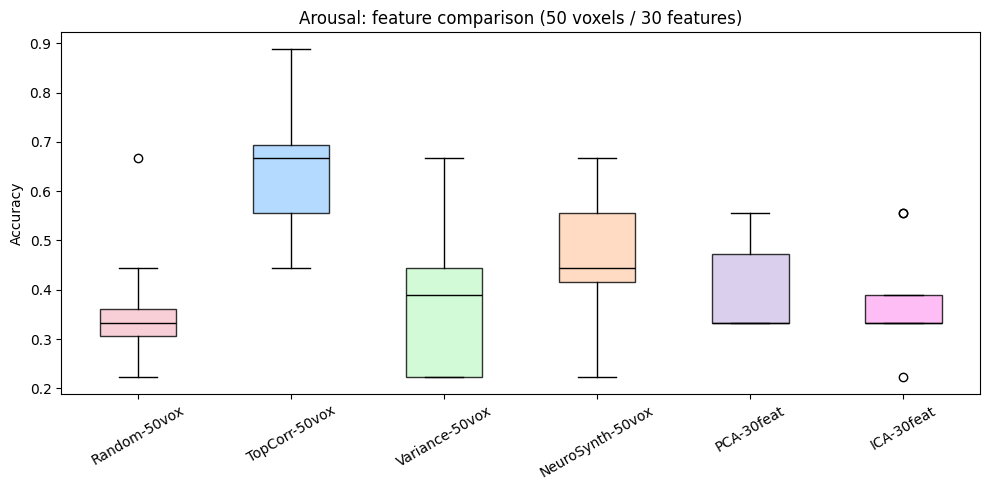

In [158]:
import matplotlib.pyplot as plt
import numpy as np

macaron = ['#f8c4cd','#a2d2ff','#c7f9cc','#ffd3b6','#d1c4e9','#ffadf4']

plt.figure(figsize=(10,5))
# 关键是打开 patch_artist=True
box = plt.boxplot(results_arousal.values(),
                  labels=results_arousal.keys(),
                  #showmeans=True,
                  patch_artist=True)

for patch, color in zip(box['boxes'], macaron):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

# 需要时给中线/均值统一黑色
plt.setp(box['medians'], color='k')
plt.setp(box['means'], color='k', marker='D')

plt.ylabel("Accuracy")
plt.title("Arousal: feature comparison (50 voxels / 30 features)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [176]:
#打印一下results_arousal的mean和std
for name, scores in results_arousal.items():
    print(f"{name}: mean={scores.mean():.3f}, std={scores.std():.3f}")

Random-50vox: mean=0.361, std=0.133
TopCorr-50vox: mean=0.653, std=0.130
Variance-50vox: mean=0.375, std=0.146
NeuroSynth-50vox: mean=0.458, std=0.130
PCA-30feat: mean=0.403, std=0.095
ICA-30feat: mean=0.375, std=0.110


In [ ]:
voxel_list = (
    list(range(0, 50, 10)) +       # 0–50 每隔 10
    list(range(50, 200, 25)) +    # 50–200 每隔 25
    list(range(200, 500, 50)) +   # 200–500 每隔 50
    list(range(500, 1001, 100))   # 500–1000 每隔 100
)


In [153]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

y_arousal = np.array(arousal_label)


def eval_accuracy(X, y):
    clf = SVC(kernel="linear")
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    return cross_val_score(clf, X, y, cv=kf).mean()


# -------------------------
# Precompute scores for all voxel numbers
# -------------------------
acc_random = []
acc_topcorr = []
acc_variance = []
acc_ns = []


print("Running voxel sweep...")

for k in voxel_list:

    if k == 0:
        # baseline: guess majority class
        acc_random.append(np.mean(y_arousal == y_arousal.mean().round()))
        acc_topcorr.append(acc_random[-1])
        acc_variance.append(acc_random[-1])
        acc_ns.append(acc_random[-1])
        continue

    # 1) Random voxels
    Xr, _ = select_random_voxels(X_clean, k=k)
    acc_random.append(eval_accuracy(Xr, y_arousal))

    # 2) TopCorr voxels
    Xt, _ = select_top_voxels(X_clean, y_arousal, k=k)
    acc_topcorr.append(eval_accuracy(Xt, y_arousal))

    # 3) Variance voxels
    Xv, _ = select_by_variance(X_clean, k=k)
    acc_variance.append(eval_accuracy(Xv, y_arousal))

    # 4) Neurosynth voxels
    try:
        Xn, _ = mask_by_neurosynth(
            X_clean,
            X_clean_3d,
            valid_2d,
            arousal_mask_path,
            threshold=3.0,
            topk=k
        )
        acc_ns.append(eval_accuracy(Xn, y_arousal))
    except:
        acc_ns.append(np.nan)

    print(f"k={k}: Rand={acc_random[-1]:.3f}, TopCorr={acc_topcorr[-1]:.3f}, Var={acc_variance[-1]:.3f}, NS={acc_ns[-1]:.3f}")

Running voxel sweep...
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 10
k=10: Rand=0.405, TopCorr=0.680, Var=0.475, NS=0.287
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 20
k=20: Rand=0.334, TopCorr=0.738, Var=0.361, NS=0.430
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 30
k=30: Rand=0.432, TopCorr=0.777, Var=0.414, NS=0.400
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 40
k=40: Rand=0.432, TopCorr=0.721, Var=0.434, NS=0.425
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 50
k=50: Rand=0.525, TopCorr=0.636, Var=0.461, N

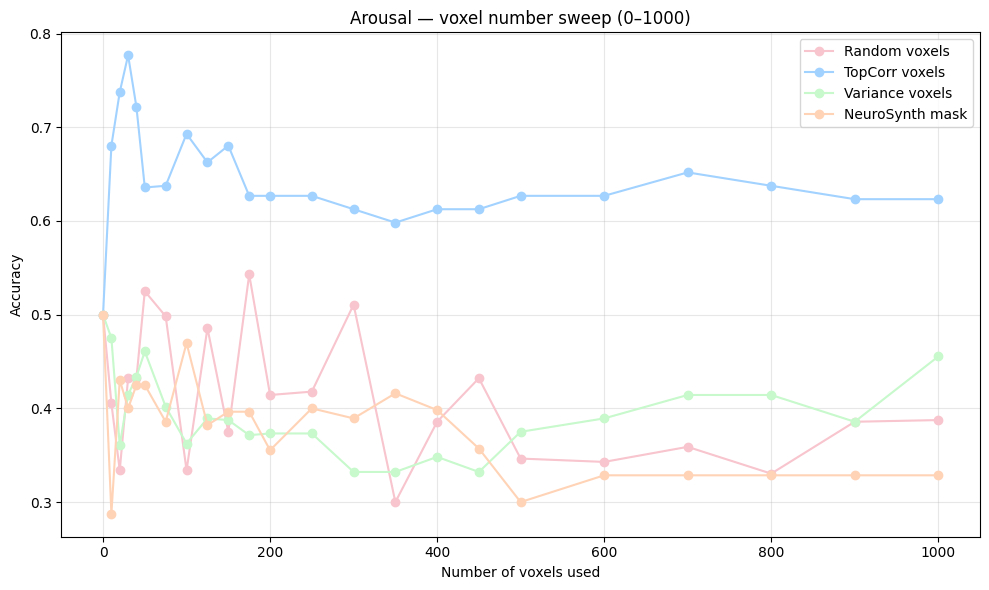

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(voxel_list, acc_random,
         label="Random voxels", marker='o', color=macaron[0])
plt.plot(voxel_list, acc_topcorr,
         label="TopCorr voxels", marker='o', color=macaron[1])
plt.plot(voxel_list, acc_variance,
         label="Variance voxels", marker='o', color=macaron[2])
plt.plot(voxel_list, acc_ns,
         label="NeuroSynth mask", marker='o', color=macaron[3])
plt.xlabel("Number of voxels used")
plt.ylabel("Accuracy")
plt.title("Arousal — voxel number sweep (0–1000)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [112]:
max_comp = 72
acc_pca_list = []
acc_ica_list = []

print("⚙️ Running PCA/ICA sweep...")

# Precompute PCA and ICA full matrices to avoid repeated cost
FULL_PCA = PCA(n_components=max_comp, random_state=0).fit_transform(X_clean)
FULL_ICA= extract_ica(X_clean, n_components=max_comp)

# 每隔5个组件评估一次
for k in range(1, max_comp, 5):

    # PCA first k components
    Xp = FULL_PCA[:, :k]
    acc_pca_list.append(eval_accuracy(Xp, y_arousal))

    # ICA first k components
    Xi = FULL_ICA[:, :k]
    acc_ica_list.append(eval_accuracy(Xi, y_arousal))

    print(f"Components={k}: PCA={acc_pca_list[-1]:.3f}, ICA={acc_ica_list[-1]:.3f}")


⚙️ Running PCA/ICA sweep...


/opt/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Components=1: PCA=0.434, ICA=0.400
Components=6: PCA=0.477, ICA=0.502
Components=11: PCA=0.416, ICA=0.571
Components=16: PCA=0.373, ICA=0.545
Components=21: PCA=0.291, ICA=0.571
Components=26: PCA=0.420, ICA=0.600
Components=31: PCA=0.418, ICA=0.600
Components=36: PCA=0.379, ICA=0.614
Components=41: PCA=0.477, ICA=0.541
Components=46: PCA=0.320, ICA=0.541
Components=51: PCA=0.375, ICA=0.504
Components=56: PCA=0.400, ICA=0.518
Components=61: PCA=0.350, ICA=0.557
Components=66: PCA=0.429, ICA=0.518
Components=71: PCA=0.316, ICA=0.457


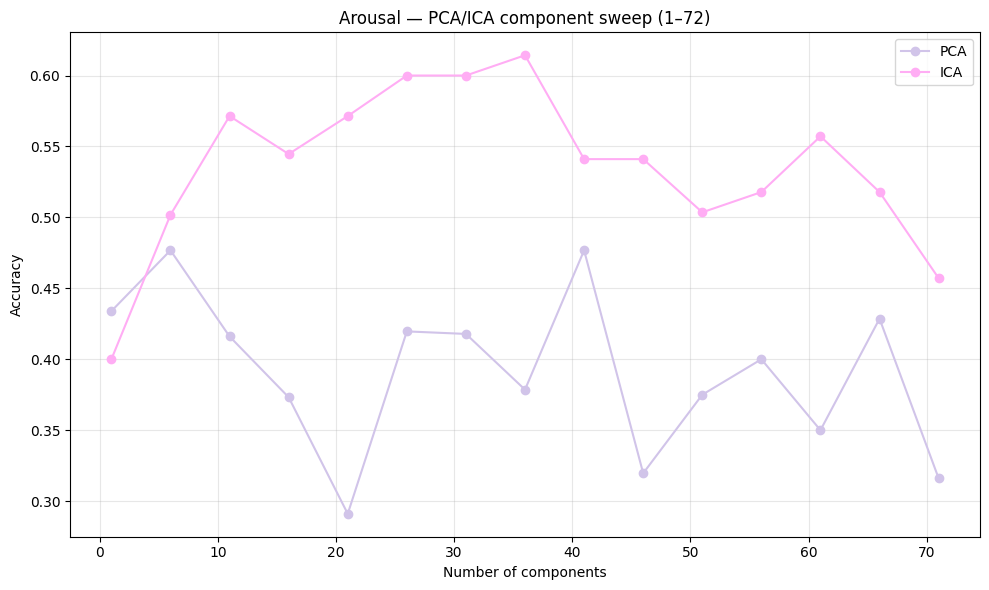

In [155]:
# -------------------------
# Plot PCA/ICA sweep
# -------------------------
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_comp, 5), acc_pca_list, label="PCA", marker='o',color=macaron[4])
plt.plot(range(1, max_comp, 5), acc_ica_list, label="ICA", marker='o',color=macaron[5])

plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.title("Arousal — PCA/ICA component sweep (1–72)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Selected top 50 voxels: [38424 35882 37499 18782 38423 40855 40856 38376 18823 43110 18783 38377
 18822 40902 35929 40809 18781 39632 40903 37459 16235 45321 16194   342
 43154 18824 38471 18741 43854 21594 16234 37458 38472 16195 38425  3885
 34948 18821 18740 24372 37538 46250 37500 27007 37460 10761 26979 21553
 43067 24373]
SVM_linear: mean=0.669, std=0.157
SVM_rbf: mean=0.752, std=0.140
SVM_poly: mean=0.710, std=0.088
LogisticRegression: mean=0.751, std=0.091
Chance Level: mean=0.487, std=0.016


/var/folders/3r/nq91dhgd71x6t7v0xthbg9vc0000gn/T/ipykernel_7429/2559305548.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results.values(), labels=results.keys(), showmeans=True)


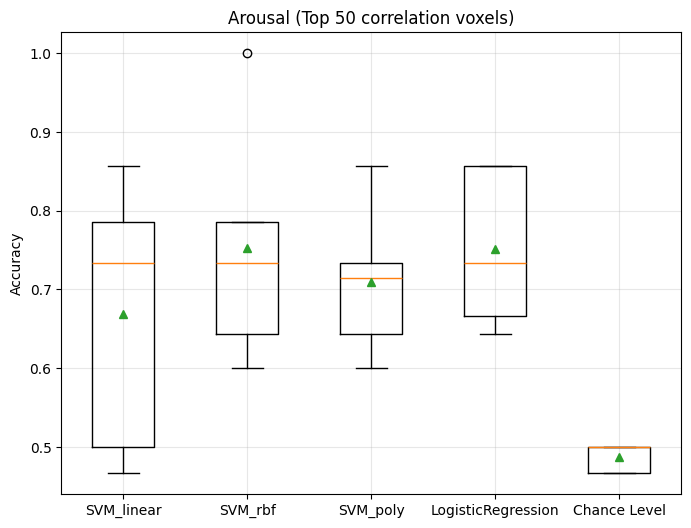

In [134]:
X = X_clean.copy()         
y = np.array(arousal_label)    


def select_top_corr_voxels(X, y, topk=50):
    corrs = np.array([pearsonr(X[:, i], y)[0] for i in range(X.shape[1])])
    corrs = np.nan_to_num(corrs)
    idx = np.argsort(np.abs(corrs))[::-1][:topk]
    return X[:, idx], idx

X_top, top_idx = select_top_corr_voxels(X, y, topk=50)
print(f"Selected top {len(top_idx)} voxels: {top_idx}")


classifiers = {
    "SVM_linear": SVC(kernel="linear", C=1, random_state=0),
    "SVM_rbf": SVC(kernel="rbf", C=1, gamma="scale", random_state=0),
    "SVM_poly": SVC(kernel="poly", degree=3, C=1, random_state=0),
    "LogisticRegression": LogisticRegression(max_iter=5000, solver='liblinear', random_state=0),
    "Chance Level": DummyClassifier(strategy="most_frequent")  # chance level
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

results = {}
for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_top, y, cv=cv, scoring="accuracy")
    results[name] = scores
    print(f"{name}: mean={scores.mean():.3f}, std={scores.std():.3f}")


plt.figure(figsize=(8,6))
plt.boxplot(results.values(), labels=results.keys(), showmeans=True)
plt.ylabel("Accuracy")
plt.title("Arousal (Top 50 correlation voxels)")
plt.grid(alpha=0.3)
plt.show()

means = [scores.mean() for scores in results.values()]
stds = [scores.std() for scores in results.values()]



/var/folders/3r/nq91dhgd71x6t7v0xthbg9vc0000gn/T/ipykernel_7429/3584535671.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(results.values(), labels=labels, patch_artist=True)


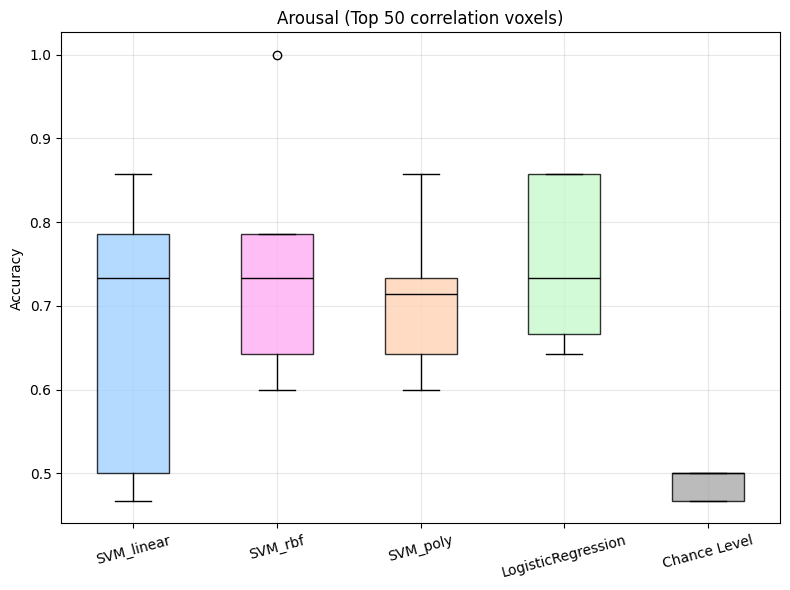

In [157]:
method_colors = {
    "SVM_linear":      '#a2d2ff',   # sky-blue
    "SVM_rbf":         '#ffadf4',   # candy-pink
    "SVM_poly":        '#ffd3b6',   # peach
    "LogisticRegression": '#c7f9cc',   # mint
    "Chance Level":    '#aaaaaa'    # 中性灰（保持低调）
}
# --- 1. 画 bar 或者 boxplot 都能通用 -------------------
labels = list(results.keys())
colors = [method_colors[l] for l in labels]

fig, ax = plt.subplots(figsize=(8, 6))
bp = ax.boxplot(results.values(), labels=labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

for item in ['medians', 'means']:
    plt.setp(bp[item], color='k')

plt.ylabel("Accuracy")
plt.title("Arousal (Top 50 correlation voxels)")
plt.xticks(rotation=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [174]:
results

{'SVM_linear': array([0.6       , 0.86666667, 0.78571429, 0.78571429, 0.42857143]),
 'SVM_rbf': array([0.73333333, 0.8       , 0.78571429, 0.85714286, 0.64285714]),
 'SVM_poly': array([0.66666667, 0.66666667, 0.71428571, 0.64285714, 0.64285714]),
 'LogisticRegression': array([0.66666667, 0.8       , 0.92857143, 0.71428571, 0.42857143]),
 'Chance Level': array([0.53333333, 0.53333333, 0.5       , 0.5       , 0.5       ])}

In [159]:
y_recall = np.array(recall_label)


NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 50


/var/folders/3r/nq91dhgd71x6t7v0xthbg9vc0000gn/T/ipykernel_7429/372627190.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(results_recall.values(),


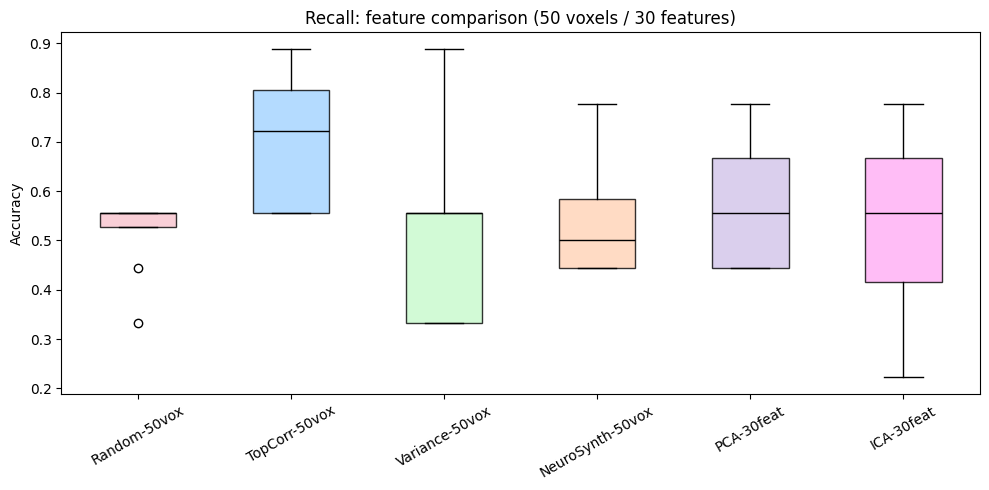

In [161]:
# ===============================================
# RECALL DECODING – unified feature comparison
# ===============================================

def run_model_and_cv(X, y, clf=None, n_splits=8):
    if clf is None:
        clf = SVC(kernel="linear")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    return cross_val_score(clf, X, y, cv=kf)

# -----------------------------
# 1. Random voxels
# -----------------------------
X_rand, _ = select_random_voxels(X_clean, k=50)
acc_rand = run_model_and_cv(X_rand, y_recall)

# -----------------------------
# 2. Top-k Corr voxels
# -----------------------------
X_topcorr, _ = select_top_voxels(X_clean, y_recall, k=50)
acc_topcorr = run_model_and_cv(X_topcorr, y_recall)

# -----------------------------
# 3. Variance voxels
# -----------------------------
X_var, _ = select_by_variance(X_clean, k=50)
acc_var = run_model_and_cv(X_var, y_recall)

# -----------------------------
# 4. PCA 30 feat
# -----------------------------
X_pca = extract_pca(X_clean, n_components=30)
acc_pca = run_model_and_cv(X_pca, y_recall)

# -----------------------------
# 5. ICA 30 feat
# -----------------------------
X_ica = extract_ica(X_clean, n_components=30)
acc_ica = run_model_and_cv(X_ica, y_recall)

# -----------------------------
# 6. Neurosynth 50 vox
# -----------------------------
X_ns, _ = mask_by_neurosynth(
    X_clean, X_clean_3d, valid_2d,
    recall_mask_path,
    threshold=3.0,
    topk=50
)
acc_ns = run_model_and_cv(X_ns, y_recall)

# Collect
results_recall = {
    "Random-50vox": acc_rand,
    "TopCorr-50vox": acc_topcorr,
    "Variance-50vox": acc_var,
    "NeuroSynth-50vox": acc_ns,
    "PCA-30feat": acc_pca,
    "ICA-30feat": acc_ica,
}

# --- plot ---
macaron = ['#f8c4cd','#a2d2ff','#c7f9cc','#ffd3b6','#d1c4e9','#ffadf4']

plt.figure(figsize=(10,5))
box = plt.boxplot(results_recall.values(),
                  labels=results_recall.keys(),
                  patch_artist=True)

for patch, color in zip(box['boxes'], macaron):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

plt.setp(box['medians'], color='k')

plt.ylabel("Accuracy")
plt.title("Recall: feature comparison (50 voxels / 30 features)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [177]:
#打印一下results_arousal的mean和std
for name, scores in results_recall.items():
    print(f"{name}: mean={scores.mean():.3f}, std={scores.std():.3f}")

Random-50vox: mean=0.514, std=0.077
TopCorr-50vox: mean=0.708, std=0.135
Variance-50vox: mean=0.514, std=0.175
NeuroSynth-50vox: mean=0.542, std=0.117
PCA-30feat: mean=0.569, std=0.117
ICA-30feat: mean=0.528, std=0.173


Running voxel sweep (RECALL)...
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 10
k=10: Rand=0.518, TopCorr=0.750, Var=0.546, NS=0.586
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 20
k=20: Rand=0.582, TopCorr=0.713, Var=0.571, NS=0.629
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 30
k=30: Rand=0.561, TopCorr=0.709, Var=0.525, NS=0.514
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 40
k=40: Rand=0.530, TopCorr=0.738, Var=0.564, NS=0.530
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 50
k=50: Rand=0.486, TopCorr=0.754, Var

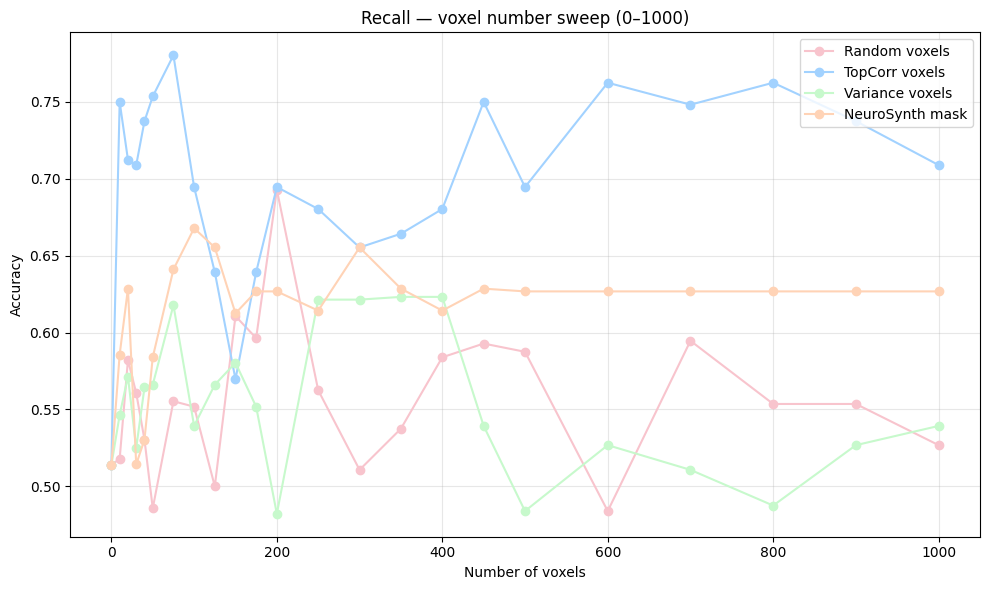

In [162]:
voxel_list = (
    list(range(0, 50, 10)) +
    list(range(50, 200, 25)) +
    list(range(200, 500, 50)) +
    list(range(500, 1001, 100))
)

def eval_accuracy(X, y):
    clf = SVC(kernel="linear")
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    return cross_val_score(clf, X, y, cv=kf).mean()


acc_random = []
acc_topcorr = []
acc_variance = []
acc_ns = []

print("Running voxel sweep (RECALL)...")

for k in voxel_list:

    if k == 0:
        chance = np.mean(y_recall == np.round(np.mean(y_recall)))
        acc_random.append(chance)
        acc_topcorr.append(chance)
        acc_variance.append(chance)
        acc_ns.append(chance)
        continue

    Xr, _ = select_random_voxels(X_clean, k=k)
    acc_random.append(eval_accuracy(Xr, y_recall))

    Xt, _ = select_top_voxels(X_clean, y_recall, k=k)
    acc_topcorr.append(eval_accuracy(Xt, y_recall))

    Xv, _ = select_by_variance(X_clean, k=k)
    acc_variance.append(eval_accuracy(Xv, y_recall))

    try:
        Xn, _ = mask_by_neurosynth(
            X_clean, X_clean_3d, valid_2d,
            recall_mask_path,
            threshold=3.0,
            topk=k
        )
        acc_ns.append(eval_accuracy(Xn, y_recall))
    except:
        acc_ns.append(np.nan)

    print(f"k={k}: Rand={acc_random[-1]:.3f}, TopCorr={acc_topcorr[-1]:.3f}, Var={acc_variance[-1]:.3f}, NS={acc_ns[-1]:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(voxel_list, acc_random,   label="Random voxels",   marker='o', color=macaron[0])
plt.plot(voxel_list, acc_topcorr,  label="TopCorr voxels",  marker='o', color=macaron[1])
plt.plot(voxel_list, acc_variance, label="Variance voxels", marker='o', color=macaron[2])
plt.plot(voxel_list, acc_ns,       label="NeuroSynth mask", marker='o', color=macaron[3])

plt.xlabel("Number of voxels")
plt.ylabel("Accuracy")
plt.title("Recall — voxel number sweep (0–1000)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


⚙️ Running PCA/ICA sweep (RECALL)...


/opt/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Components=1: PCA=0.391, ICA=0.348
Components=6: PCA=0.580, ICA=0.348
Components=11: PCA=0.625, ICA=0.505
Components=16: PCA=0.527, ICA=0.505
Components=21: PCA=0.529, ICA=0.493
Components=26: PCA=0.570, ICA=0.493
Components=31: PCA=0.539, ICA=0.448
Components=36: PCA=0.570, ICA=0.420
Components=41: PCA=0.568, ICA=0.429
Components=46: PCA=0.525, ICA=0.477
Components=51: PCA=0.566, ICA=0.502
Components=56: PCA=0.527, ICA=0.434
Components=61: PCA=0.509, ICA=0.511
Components=66: PCA=0.511, ICA=0.537
Components=71: PCA=0.584, ICA=0.509


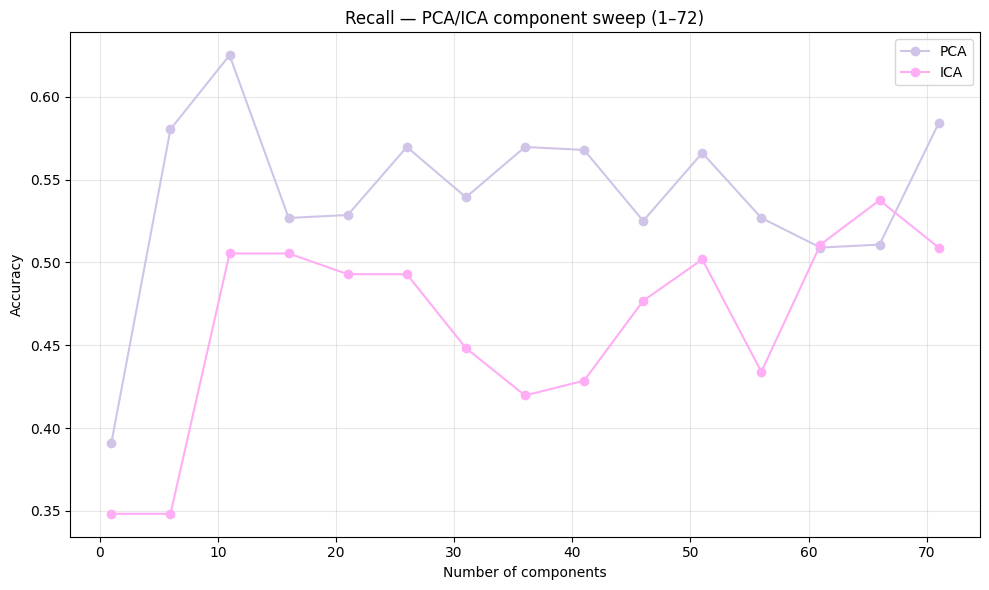

In [165]:
max_comp = 72
acc_pca_list = []
acc_ica_list = []

print("⚙️ Running PCA/ICA sweep (RECALL)...")

FULL_PCA = PCA(n_components=max_comp, random_state=0).fit_transform(X_clean)
FULL_ICA = extract_ica(X_clean, n_components=max_comp)

for k in range(1, max_comp, 5):

    acc_pca_list.append(eval_accuracy(FULL_PCA[:, :k], y_recall))
    acc_ica_list.append(eval_accuracy(FULL_ICA[:, :k], y_recall))

    print(f"Components={k}: PCA={acc_pca_list[-1]:.3f}, ICA={acc_ica_list[-1]:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_comp, 5), acc_pca_list, label="PCA", marker='o', color=macaron[4])
plt.plot(range(1, max_comp, 5), acc_ica_list, label="ICA", marker='o', color=macaron[5])

plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.title("Recall — PCA/ICA component sweep (1–72)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/3r/nq91dhgd71x6t7v0xthbg9vc0000gn/T/ipykernel_7429/472434763.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(results.values(), labels=labels, patch_artist=True)


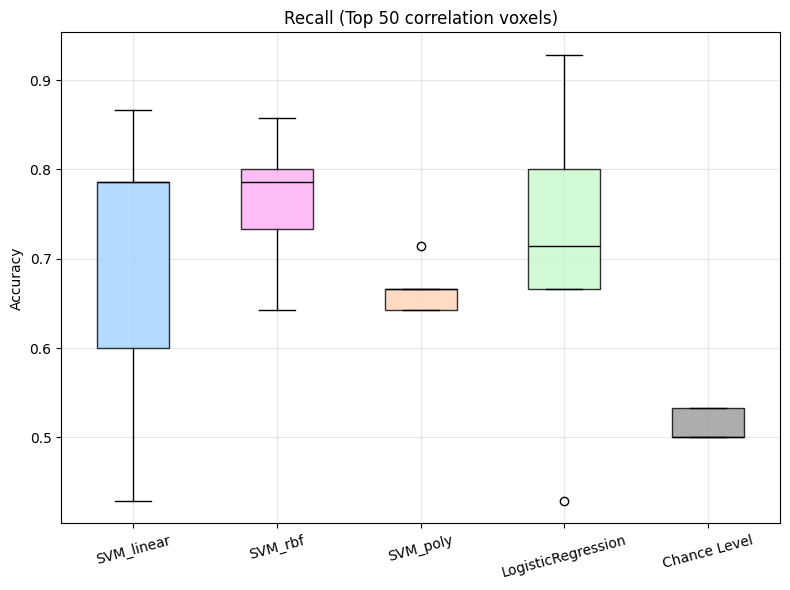

In [166]:
X_top, top_idx = select_top_corr_voxels(X_clean, y_recall, topk=50)

classifiers = {
    "SVM_linear": SVC(kernel="linear", C=1, random_state=0),
    "SVM_rbf": SVC(kernel="rbf", C=1, gamma="scale", random_state=0),
    "SVM_poly": SVC(kernel="poly", degree=3, C=1, random_state=0),
    "LogisticRegression": LogisticRegression(max_iter=5000, solver='liblinear', random_state=0),
    "Chance Level": DummyClassifier(strategy="most_frequent")
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

results = {name: cross_val_score(clf, X_top, y_recall, cv=cv)
           for name, clf in classifiers.items()}

method_colors = {
    "SVM_linear":      '#a2d2ff',
    "SVM_rbf":         '#ffadf4',
    "SVM_poly":        '#ffd3b6',
    "LogisticRegression": '#c7f9cc',
    "Chance Level":    '#999999'
}

labels = list(results.keys())
colors = [method_colors[l] for l in labels]

fig, ax = plt.subplots(figsize=(8, 6))
bp = ax.boxplot(results.values(), labels=labels, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.8)

plt.setp(bp['medians'], color='k')

plt.ylabel("Accuracy")
plt.title("Recall (Top 50 correlation voxels)")
plt.xticks(rotation=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [175]:
#打印一下results的mean和std
for name, scores in results.items():
    print(f"{name}: mean={scores.mean():.3f}, std={scores.std():.3f}")

SVM_linear: mean=0.693, std=0.159
SVM_rbf: mean=0.764, std=0.072
SVM_poly: mean=0.667, std=0.026
LogisticRegression: mean=0.708, std=0.165
Chance Level: mean=0.513, std=0.016


3D volume shape: (67, 80, 46)
NS shape needs to be replaced.
Neurosynth original: (91, 109, 91)
fMRI shape: (67, 80, 46)
Resampled NS shape: (67, 80, 46)
Selected voxels: 50
Saved nifti maps to ./viz_outputs
[fetch_atlas_harvard_oxford] Dataset found in /Users/OrangE/nilearn_data/fsl


/var/folders/3r/nq91dhgd71x6t7v0xthbg9vc0000gn/T/ipykernel_7429/4009800673.py:117: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  atlas_resampled = resample_to_img(ho.maps, nifti_topcorr, interpolation='nearest')
/var/folders/3r/nq91dhgd71x6t7v0xthbg9vc0000gn/T/ipykernel_7429/4009800673.py:117: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas_resampled = resample_to_img(ho.maps, nifti_topcorr, interpolation='nearest')


Top overlapping atlas regions (TopCorr):
  Parahippocampal Gyrus, posterior division: 1 voxels

Variance:
  Occipital Fusiform Gyrus: 3 voxels
  Temporal Fusiform Cortex, posterior division: 2 voxels
  Lateral Occipital Cortex, inferior division: 2 voxels
  Lingual Gyrus: 2 voxels
  Inferior Temporal Gyrus, posterior division: 1 voxels
  Temporal Pole: 1 voxels
  Occipital Pole: 1 voxels
  Middle Temporal Gyrus, temporooccipital part: 1 voxels

NeuroSynth:


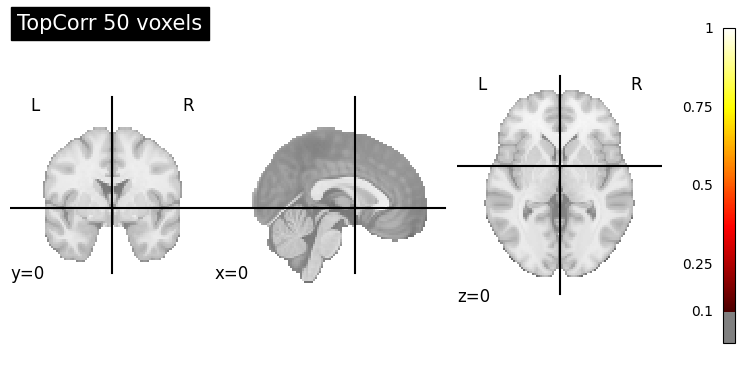

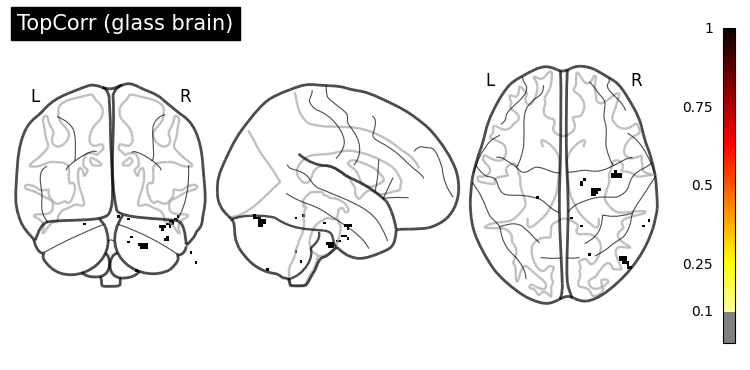

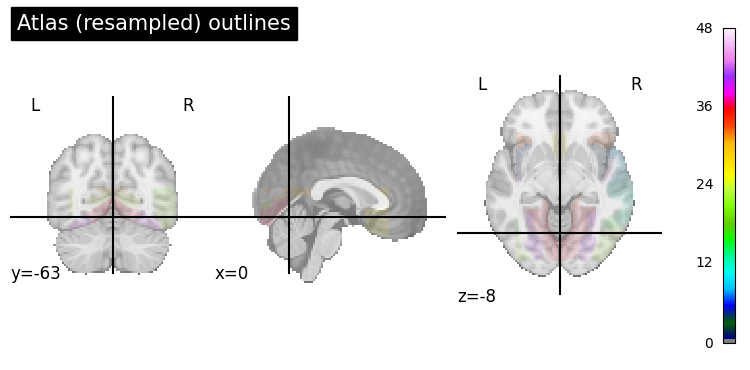

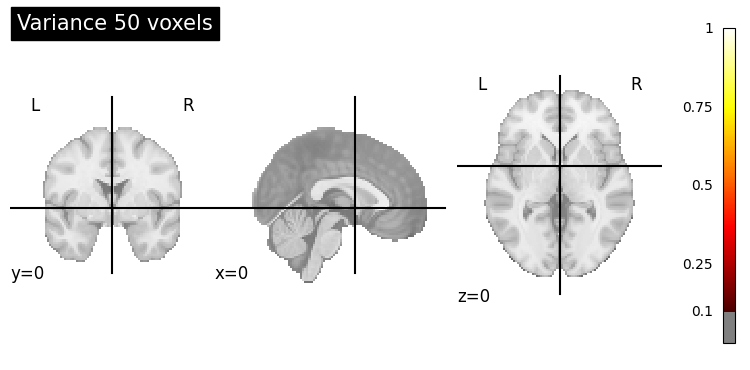

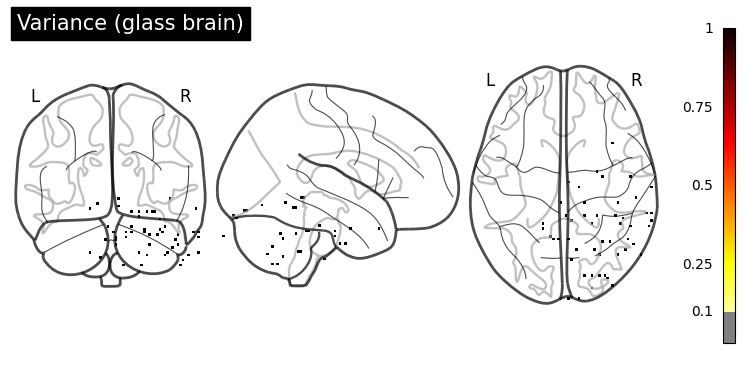

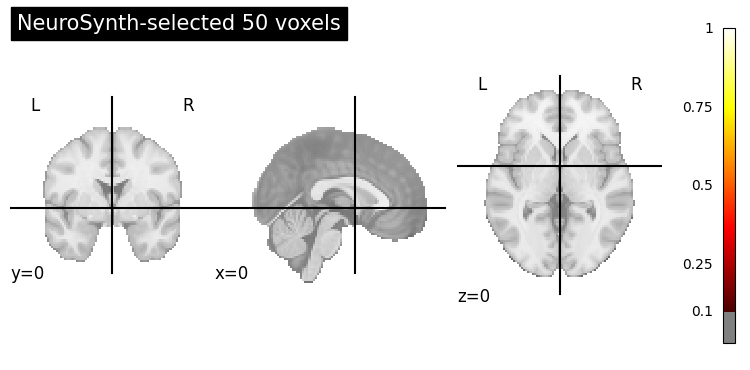

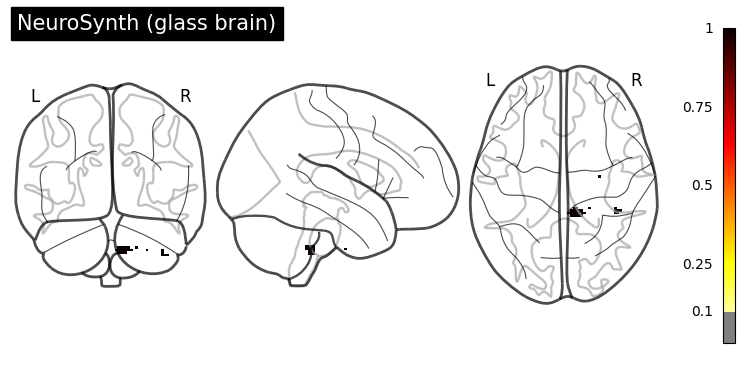

In [173]:
# ============================================================================
# Visualize selected voxels in 3D and label main brain regions
# - methods: NeuroSynth, TopCorr, Variance
# - each method: 50 voxels
# - outputs: nifti maps, slice plots, glass brain, atlas region overlap table
# ============================================================================
import numpy as np
import nibabel as nib
from nilearn.image import resample_to_img, new_img_like
from nilearn import plotting, datasets
import matplotlib.pyplot as plt
import os
from collections import Counter

# --------------------------
# 1. Helper: map selected indices (relative to X_clean) -> 3D volume nifti
# --------------------------
def build_nifti_from_selected(selected_idx_rel, valid_mask_flat, template_3d, affine=None, value_map=None, order='F'):
    """
    selected_idx_rel: indices into X_clean columns (0..n_kept-1)
    valid_mask_flat: boolean mask (len = nx*ny*nz) indicating which flat indices were kept into X_clean
    template_3d: a 3D ndarray (nx,ny,nz) used for shape and to create reference image
    affine: 4x4 affine matrix (if None, will create identity-ish)
    value_map: optional array of same length as selected_idx_rel to set voxel values (e.g. correlations)
    """
    nx, ny, nz = template_3d.shape
    flat_len = nx * ny * nz
    # indices in full flattened space that correspond to X_clean columns
    kept_indices = np.where(valid_mask_flat)[0]   # mapping: rel_idx -> full_flat_idx = kept_indices[rel_idx]
    # get full flattened indices for selected voxels
    full_selected_flat_idx = kept_indices[selected_idx_rel]

    # create full flat volume
    vol_flat = np.zeros(flat_len, dtype=float)
    if value_map is None:
        values = np.ones(len(full_selected_flat_idx), dtype=float)
    else:
        values = np.array(value_map, dtype=float)
    vol_flat[full_selected_flat_idx] = values

    # reshape back to 3D using same ordering as used earlier (we used order='F' when flattening)
    vol_3d = vol_flat.reshape((nx, ny, nz), order=order)

    if affine is None:
        # try to take affine from template if template is a nib object; if template is array, we'll build a simple affine
        affine = np.eye(4)
        affine[0,0] = -2.75; affine[1,1] = 2.75; affine[2,2] = 4.0
        affine[0,3] = 90.75; affine[1,3] = -126.5; affine[2,3] = -72.0

    nifti = nib.Nifti1Image(vol_3d, affine)
    return nifti, vol_3d

# --------------------------
# 2. Prepare: get template shape & affine
# --------------------------
# using your X_clean_3d returned from clean_data earlier
# X_clean_3d shape expected (n_samples, nx, ny, nz)
nx, ny, nz = X_clean_3d.shape[1:]
print("3D volume shape:", (nx, ny, nz))

# create a template image from first volume (we need affine)
# if X_clean_3d was not created with a meaningful affine, we still use a synthetic affine consistent with previous code
plate_affine = None
# if you loaded a NIfTI earlier you might have an affine; otherwise we create one as in mask_by_neurosynth
# attempt to use an existing Neurosynth image affine if present
try:
    ns_img = nib.load(arousal_mask_path)
    template_affine = ns_img.affine
except Exception:
    # fallback to synthetic affine (same as used previously)
    template_affine = np.eye(4)
    template_affine[0,0] = -2.75; template_affine[1,1] = 2.75; template_affine[2,2] = 4.0
    template_affine[0,3] = 90.75; template_affine[1,3] = -126.5; template_affine[2,3] = -72.0

template_3d_example = X_clean_3d[0]  # use shape only

# --------------------------
# 3. Get selected indices for each method (relative to X_clean)
#    - TopCorr: re-use your previous function to get idx (returns rel indices)
#    - Variance: re-use select_by_variance which returned idx relative to X_clean
#    - NeuroSynth: use mask_by_neurosynth which returned selected_idx (already relative to X_clean)
# --------------------------
# TopCorr
_, top_idx_rel = select_top_voxels(X_clean, y_arousal, k=50)  # relative indices into X_clean columns

# Variance
_, var_idx_rel = select_by_variance(X_clean, k=50)

# NeuroSynth (ensure using arousal mask path)
X_ns_tmp, ns_idx_rel = mask_by_neurosynth(X_clean, X_clean_3d, valid_2d, arousal_mask_path, threshold=3.0, topk=50)

# --------------------------
# 4. Build nifti images
# --------------------------
nifti_topcorr, vol_top = build_nifti_from_selected(top_idx_rel, valid_3d, template_3d_example, affine=template_affine)
nifti_variance, vol_var = build_nifti_from_selected(var_idx_rel, valid_3d, template_3d_example, affine=template_affine)
nifti_ns, vol_ns = build_nifti_from_selected(ns_idx_rel, valid_3d, template_3d_example, affine=template_affine)

# optional: save nifti files
out_dir = "./viz_outputs"
os.makedirs(out_dir, exist_ok=True)
nib.save(nifti_topcorr, os.path.join(out_dir, "topcorr_50vox.nii.gz"))
nib.save(nifti_variance, os.path.join(out_dir, "variance_50vox.nii.gz"))
nib.save(nifti_ns, os.path.join(out_dir, "neurosynth_50vox.nii.gz"))
print("Saved nifti maps to", out_dir)

# --------------------------
# 5. Load an atlas (Harvard-Oxford cortical + subcortical maxprob atlas) for labelling
# --------------------------
# This will download atlas if not present (internet required the first time)
ho = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')  # path to nifti + labels
atlas_img = ho.maps if not isinstance(ho.maps, str) else nib.load(ho.maps)
atlas_data = atlas_img.get_fdata().astype(int).flatten(order='F')  # flatten in same order
atlas_labels = ho.labels  # list of region names (0 is background)

# Resample atlas to our template if needed (ensure same shape)
atlas_resampled = resample_to_img(ho.maps, nifti_topcorr, interpolation='nearest')
atlas_res_data = atlas_resampled.get_fdata().astype(int).flatten(order='F')

# --------------------------
# 6. Function: report top overlapping atlas regions
# --------------------------
def top_atlas_overlap(nifti_img, atlas_flat, valid_mask_flat, top_n=6):
    # nifti_img: nib image object
    data = nifti_img.get_fdata().flatten(order='F')
    # get indices that are active (>0)
    active_idx = np.where(data != 0)[0]
    # map each active index to atlas label
    atlas_labels_at_vox = atlas_flat[active_idx]
    cnt = Counter(atlas_labels_at_vox)
    # remove background label 0
    if 0 in cnt:
        del cnt[0]
    # get most common labels
    top = cnt.most_common(top_n)
    return top

top_topcorr = top_atlas_overlap(nifti_topcorr, atlas_res_data, valid_3d, top_n=8)
top_var = top_atlas_overlap(nifti_variance, atlas_res_data, valid_3d, top_n=8)
top_ns = top_atlas_overlap(nifti_ns, atlas_res_data, valid_3d, top_n=8)

print("Top overlapping atlas regions (TopCorr):")
for lab_idx, n in top_topcorr:
    print(f"  {ho.labels[lab_idx]}: {n} voxels")
print("\nVariance:")
for lab_idx, n in top_var:
    print(f"  {ho.labels[lab_idx]}: {n} voxels")
print("\nNeuroSynth:")
for lab_idx, n in top_ns:
    print(f"  {ho.labels[lab_idx]}: {n} voxels")

# --------------------------
# 7. Visualization: slices + glass brain + ROI overlay
# --------------------------
display_kwargs = dict(cmap='hot', threshold=0.1, vmax=None, display_mode='ortho', cut_coords=(0, 0, 0))

# a) TopCorr
fig1 = plotting.plot_stat_map(nifti_topcorr, title="TopCorr 50 voxels", **display_kwargs)
plotting.plot_glass_brain(nifti_topcorr, title="TopCorr (glass brain)", threshold=0.1)
# overlay atlas outlines (resampled) as contours
plotting.plot_roi(atlas_resampled, title="Atlas (resampled) outlines", alpha=0.1)

# b) Variance
fig2 = plotting.plot_stat_map(nifti_variance, title="Variance 50 voxels", **display_kwargs)
plotting.plot_glass_brain(nifti_variance, title="Variance (glass brain)", threshold=0.1)

# c) NeuroSynth
fig3 = plotting.plot_stat_map(nifti_ns, title="NeuroSynth-selected 50 voxels", **display_kwargs)
plotting.plot_glass_brain(nifti_ns, title="NeuroSynth (glass brain)", threshold=0.1)

# optionally: annotate the top atlas regions on the plot (text box)
def annotate_regions(ax, top_list, labels_list, xpos=0.05, ypos=0.02):
    txt = "\n".join([f"{labels_list[idx]}: {count}" for idx, count in top_list])
    ax.text(xpos, ypos, txt, transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

# Note: depending on backend, annotate on matplotlib axes from the returned figures could be needed.
# For interactive jupyter, you can display the figures above and also print the top regions (we already printed them).

plt.show()
